In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import scipy.misc

import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

import dense_correspondence
from dense_correspondence.evaluation.evaluation import *
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
import dense_correspondence.correspondence_tools.correspondence_finder as correspondence_finder
from dense_correspondence.correspondence_tools.correspondence_finder import random_sample_from_masked_image, pinhole_projection_image_to_world
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
import dense_correspondence.evaluation.plotting as dc_plotting
%matplotlib inline 
utils.set_cuda_visible_devices([0])


setting CUDA_VISIBLE_DEVICES =  0,


In [3]:
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation
dcn = dce.load_network_from_config("cup_bottlesauce_elephant_cat_pear_unit_8")
dataset = dcn.load_training_dataset()
camera_intrinsics = dataset.get_camera_intrinsics("elephant")

Using SpartanDataset:
   - in train mode
   - number of scenes 5
   - total images:     18650


In [5]:
def match_index_and_norm_diff(query, features, cond=None):
    """
    Assumes that query and features both have shape (N, D).
    query: ndarray (D,)
    features: ndarray (N, D)    
    """
    
    if cond is None: 
        norm_diffs = np.sqrt(np.sum(np.square(features - query), axis=1)) 
        
    elif cond == "ppf":
        f1 = features[:, 1:]
        D = f1.shape[1]
        f2 = np.concatenate((f1[:, D//2:], f1[:, :D//2]), axis=1)
                
        norm_diffs1 = np.sqrt(np.sum(np.square(f1 - query[1:]), axis=1))
        norm_diffs2 = np.sqrt(np.sum(np.square(f2 - query[1:]), axis=1))
        norm_diffs = np.minimum(norm_diffs1, norm_diffs2)
    
        feature_cond = features[:, 0]
        query_cond = query[0]
        mask = np.logical_and(feature_cond > 5./7*query_cond, feature_cond < 9./7*query_cond).astype(np.float)
        norm_diffs = mask * norm_diffs + np.nan_to_num((1-mask) * float("inf") * np.ones(norm_diffs.shape))
    else:
        assert 1 == 0 
        
    best_match_index = np.argmin(norm_diffs)
    best_match_diff = norm_diffs[best_match_index]
    result = np.array([best_match_index, best_match_diff])
        
    #         candidate_indices = np.argwhere(np.logical_and(ppfs[:,0] > 5/7*ppf_target[0], ppfs[:,0] < 9/7*ppf_target[0])).T[0]

        
    return result

def simple_match(f1, f2, cond=None):
    """
    Simple brute force matching between features1 and features2.
    f1: ndarray of shape (N, ... )
    f2: ndarray of shape (N, ....)
    fn: None, "ppf"
    Returns indices of matches. Also does some filtering 
    to make sure that the best match of f1 is the best match of f2. 
    """
    
    f1 = f1.reshape((f1.shape[0], -1)) 
    f2 = f2.reshape((f2.shape[0], -1))

    f1_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f2, cond), 1, f1)
    f2_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f1, cond), 1, f2)
    
    best_matches = []
    for i in range(f1_matches.shape[0]):
        norm_diff = f1_matches[i, 1]
        best_match_index = int(f1_matches[i, 0])
        if f2_matches[best_match_index, 0] == i: # If they're the best matches of each other
            best_matches.append((i, best_match_index, norm_diff))
            
    return best_matches


def draw_orb_matches(img1, kp1, des1, img2, kp2, des2, match_type="hamming", num_matches=10):
    dist = 0.01 # placeholder constant for opencv

    if match_type == "hamming": 
        print("Using openCV norm_hammings")
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.    
        matches = bf.match(des1,des2)
    else:
        print("Using simple match")
        best_matches_lst = simple_match(des1, des2)
        matches = [cv2.DMatch(x[0], x[1], x[2]) for x in best_matches_lst]

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:num_matches], None, flags=2)

    plt.figure(figsize = (20, 10))
    plt.imshow(img3)
    plt.show()
    
def run_dcn_on_image(dcn, dataset, img):
    """
    Run DCN on PIL img. use of dataset is a hack, just need to ge the descriptor image stats 
    which actually just uses a constant for std and mean. 
    """
    rgb_a_tensor = dataset.rgb_image_to_tensor(img)
    res_a = dcn.forward_single_image_tensor(rgb_a_tensor).data.cpu().numpy()
    descriptor_image_stats = dcn.descriptor_image_stats
    res_a_norm = dc_plotting.normalize_descriptor(res_a, descriptor_image_stats["mask_image"])
    return res_a_norm

def run_ORB(heap_name, target_name, num_matches=5):
    """Run baseline ORB. """
    orb = cv2.ORB_create()

    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)

    # target = target * target_mask

    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)

    kp1, des1 = orb.detectAndCompute(target,None)
    kp2, des2 = orb.detectAndCompute(heap,None)
    
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches)

def run_ORB_and_dense_descriptors(dcn, dataset, heap_name, target_name, num_matches=5):
    """Use ORB keypoints + dense descriptors. """
    orb = cv2.ORB_create()

    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    
    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    
    # be careful, OpenCV format is  (u,v) = (right, down)
    kp1_map = lambda x: target_descriptors[x[1], x[0]]
    kp2_map = lambda x: heap_descriptors[x[1], x[0]]

    # # find the keypoints with ORB
    kp1 = orb.detect(target,None)
    kp1_array = np.array([x.pt for x in kp1]).reshape(-1, 2).astype(np.int)
    des1 = np.apply_along_axis(kp1_map, 1, kp1_array)
    
    kp2 = orb.detect(heap,None)
    kp2_array = np.array([x.pt for x in kp2]).reshape(-1, 2).astype(np.int)
    des2 = np.apply_along_axis(kp2_map, 1, kp2_array)
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches, match_type="simple")

def run_dense_descriptor_original_match(dcn, dataset, heap_name, target_name, num_matches=5, patch_size=None):
    """Use the original dense descriptor sampling + matching method"""
    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)
    
    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    heap_mask = np.load("images/heaps/{}/heap_mask.npy".format(heap_name)).astype(np.bool)
    
    DCE.single_image_pair_qualitative_analysis(dcn, dataset, target, heap, target_mask, heap_mask, num_matches, patch_size)

    
def compute_PPF_feature(uv_A, uv_B, img, des, camera_intrinsics):
    """
    Computes PPF feature from uv_A and uv_B. These are in UV (openCV) format. 
    Camera intrinsics should be in one of the first cells. 
    
    img is the input "depth rgb" image. Bc it was generated with img = actual_depth / 0.2, 
    the actual depth is img * 0.2
    
    Descriptor is [weight * distance, des_A...., desB....]
    """
    
#     if uv_B[0] < uv_A[0]:
#         uv_A, uv_B = uv_B, uv_A
#     elif uv_B[0] == uv_A[0] and uv_B[1] < uv_A[1]:
#         uv_A, uv_B = uv_B, uv_A
    
    # !! HACK !! 
    depth_A = 0.2 * img[uv_A[1], uv_A[0], 0]
    depth_B = 0.2 * img[uv_B[1], uv_B[1], 0]
    des_A = des[uv_A[1], uv_A[0], :]
    des_B = des[uv_B[1], uv_B[0], :]
    
    pos_in_camera_frameA = pinhole_projection_image_to_world(uv_A, depth_A, camera_intrinsics.K)
    pos_in_camera_frameB = pinhole_projection_image_to_world(uv_B, depth_B, camera_intrinsics.K)
    
    distance = np.sqrt(np.sum((pos_in_camera_frameA - pos_in_camera_frameB)**2))
#     dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
#     distance = dist(uv_A, uv_B)
    ppf = np.concatenate((np.array([distance]), des_A, des_B))

    return ppf


def generate_PPF_samples(img, des, mask, num_samples=5):
    """Generate np.array of shape (N**2 x PPF_dim) sample features. 
    Returns list of (UV_A, UV_B) samples. 
    """
    dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    mask = mask[:, :, 0].astype(np.int)    
    sampled_idx_list = random_sample_from_masked_image(mask, num_samples)
    
    # If the list is empty, return an empty list
    if len(sampled_idx_list) == 0:
        return dataframe_list
    
    ppf_lst = []
    coord_lst = []
    
    for i in range(num_samples):
        for j in range(i+1, num_samples):            
            uv_A = [sampled_idx_list[1][i], sampled_idx_list[0][i]]
            uv_B = [sampled_idx_list[1][j], sampled_idx_list[0][j]]
            if dist(uv_A, uv_B) > 20: # Basic: Increase pixel distance. 
                                      # TODO: Increase physical spatial difference
                                      # TODO: Increase feature space difference
                coord_lst.append((uv_A, uv_B))
                ppf_lst.append(compute_PPF_feature(uv_A, uv_B, img, des, camera_intrinsics))
                
    ppf_lst = np.array(ppf_lst)
    coord_lst = np.array(coord_lst)
    return ppf_lst, coord_lst


def run_PPF_match(dcn, dataset, heap_name, target_name, num_samples):
    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    heap_mask = np.load("images/heaps/{}/heap_mask.npy".format(heap_name)).astype(np.bool)
    obj1_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)
    obj2_mask = np.load("images/heaps/{}/obj2_mask.npy".format(heap_name)).astype(np.bool)

    target_PPF, target_PPF_coords = generate_PPF_samples(target, target_descriptors, target_mask)
    obj1_PPF, obj1_PPF_coords = generate_PPF_samples(target, target_descriptors, obj1_mask, num_samples)
    obj2_PPF, obj2_PPF_coords = generate_PPF_samples(target, target_descriptors, obj2_mask, num_samples)
    
#     target_obj1 = sorted(simple_match(target_PPF, obj1_PPF), key=lambda x:x[2])
#     target_obj2 = sorted(simple_match(target_PPF, obj2_PPF), key=lambda x:x[2])

    


In [9]:
# x_mask = np.load("images/heaps/blackshoes_cat" + "/heap_mask.npy")

# left_mask = np.zeros(x_mask.shape)
# for i in range(left_mask.shape[0]):
#     for j in range(left_mask.shape[1]):
#         if j < left_mask.shape[1]//2:
#             left_mask[i, j, :] = [1, 1, 1]


# obj1_mask = x_mask * left_mask
# obj2_mask = x_mask * (1 - left_mask)

# np.save("images/heaps/blackshoes_cat" + "/obj1_mask.npy", obj1_mask)

# np.save("images/heaps/blackshoes_cat"  + "/obj2_mask.npy", obj2_mask)

In [9]:
target_name = "cat"
heap_name = "blackshoes_cat"

target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
# target_img_rgb = Image.open("images/targets/{}/target_rgb.png".format(target_name)).convert('RGB')
target = np.array(target_img)
target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
# target_descriptors = run_dcn_on_image(dcn, dataset, target_img_rgb)
target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

# target_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
# target = np.array(target_img)
# target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
# target_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)
# obj2_mask = np.load("images/heaps/{}/obj2_mask.npy".format(heap_name)).astype(np.bool)

heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
# heap_img_rgb = Image.open("images/heaps/{}/heap_rgb.png".format(heap_name)).convert('RGB')
heap = np.array(heap_img)
heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
# heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img_rgb)
obj1_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)
obj2_mask = np.load("images/heaps/{}/obj2_mask.npy".format(heap_name)).astype(np.bool)

# plt.imshow(target_descriptors * target_mask)
# plt.figure()
# plt.imshow(heap_descriptors * (obj1_mask + obj2_mask))
# plt.figure()


ppf_t, coord_t = generate_PPF_samples(target, target_descriptors, target_mask, 100)

# Generate ppfs for each object in the heap
ppfs1, coords1 = generate_PPF_samples(heap, heap_descriptors, obj1_mask, 100)
ppfs2, coords2 = generate_PPF_samples(heap, heap_descriptors, obj2_mask, 100)

# Combine the ppfs. These are NOT sorted by distance yet. Optimize this later. 
ppfs = np.concatenate((ppfs1, ppfs2), axis=0)
coords = np.concatenate((coords1, coords2), axis=0)
# sort_by_distance_i = ppfs[:, 0].argsort()
# ppfs, coords = ppfs[sort_by_distance_i], coords[sort_by_distance_i]

best_matches_lst = simple_match(ppf_t, ppfs, cond="ppf")

print("# of possible matches: ", len(best_matches_lst))
kp1, kp2, matches = [], [], []
diam = 0.01
# dist = 0.01

for x, match in enumerate(best_matches_lst):
    i, j, dist = match    
    kp1.append(cv2.KeyPoint(coord_t[i, 0, 0], coord_t[i, 0, 1], diam))
    kp1.append(cv2.KeyPoint(coord_t[i, 1, 0], coord_t[i, 1, 1], diam))
    kp2.append(cv2.KeyPoint(coords[j, 0, 0], coords[j, 0, 1], diam))
    kp2.append(cv2.KeyPoint(coords[j, 1, 0], coords[j, 1, 1], diam))
    matches.append(cv2.DMatch(x*2, x*2, dist))
    matches.append(cv2.DMatch(x*2+1, x*2+1, dist))
    
matches = sorted(matches, key = lambda x:x.distance)

    
    
img3 = cv2.drawMatches(target,kp1,heap,kp2,matches[:10], None, flags=2)

plt.figure(figsize = (20, 10))
plt.imshow(img3)
plt.show()

normalizing descriptor norm
normalizing descriptor norm


/home/davidtseng/pytorch-dense-correspondence/env/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


('# of possible matches: ', 633)


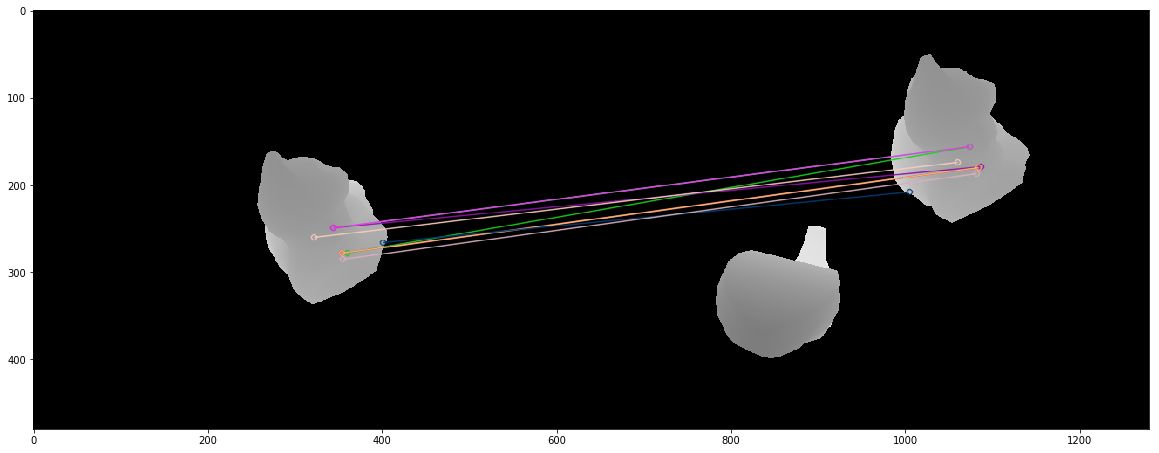

In [10]:
print("# of possible matches: ", len(best_matches_lst))
kp1, kp2, matches = [], [], []
diam = 0.01
# dist = 0.01

for x, match in enumerate(best_matches_lst):
    i, j, dist = match    
    kp1.append(cv2.KeyPoint(coord_t[i, 0, 0], coord_t[i, 0, 1], diam))
    kp1.append(cv2.KeyPoint(coord_t[i, 1, 0], coord_t[i, 1, 1], diam))
    kp2.append(cv2.KeyPoint(coords[j, 0, 0], coords[j, 0, 1], diam))
    kp2.append(cv2.KeyPoint(coords[j, 1, 0], coords[j, 1, 1], diam))
    matches.append(cv2.DMatch(x*2, x*2, dist))
    matches.append(cv2.DMatch(x*2+1, x*2+1, dist))
    
matches = sorted(matches, key = lambda x:x.distance)

    
    
img3 = cv2.drawMatches(target,kp1,heap,kp2,matches[:10], None, flags=2)

plt.figure(figsize = (20, 10))
plt.imshow(img3)
plt.show()

[36.71856846  0.05620247  0.51265819  0.70130403  0.06573068  0.52341691
  0.70263445]
[[182 261]
 [273 251]]


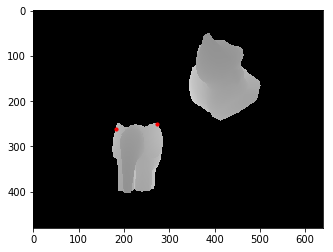

In [39]:
#==================== Example PPF matching with chosen target =====================


target_name = "elephant"
heap_name = "elephant_cat"

target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
target = np.array(target_img)
target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
heap = np.array(heap_img)
heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
heap_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)

ppfs, coords = generate_PPF_samples(heap, heap_descriptors, heap_mask, 100)

uv_A = [279, 161]
uv_B = [355, 161]
ppf_target = compute_PPF_feature(uv_A, uv_B, target, target_descriptors, camera_intrinsics )
print(ppf_target)

candidate_indices = np.argwhere(np.logical_and(ppfs[:,0] > 5./7*ppf_target[0], ppfs[:,0] < 9./7*ppf_target[0])).T[0]

ppfs = ppfs[candidate_indices]
ppfs = ppfs[:, 1:]
ppf_target = ppf_target[1:]
coords = coords[candidate_indices]
index, diff = match_index_and_norm_diff(ppf_target, ppfs)
index = int(index)

plt.figure()
out = coords[index]
print(out)

plt.imshow(heap)
plt.scatter(x=out.T[0], y=out.T[1], c='r', s=10)
# plt.scatter(x=[279,355], y=[161, 161], c='r', s=10)
# 


# print(ppf_target)

ORB: 
Using openCV norm_hammings


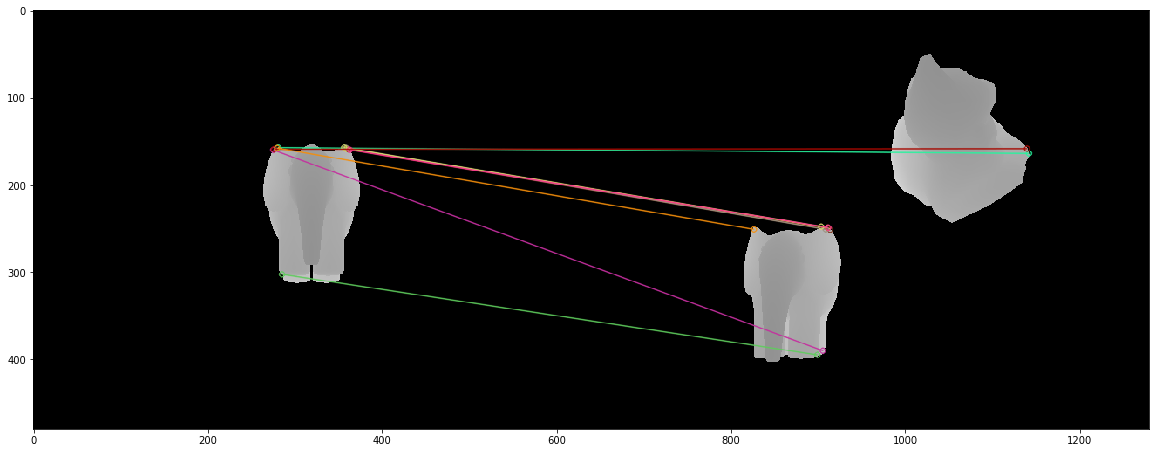

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


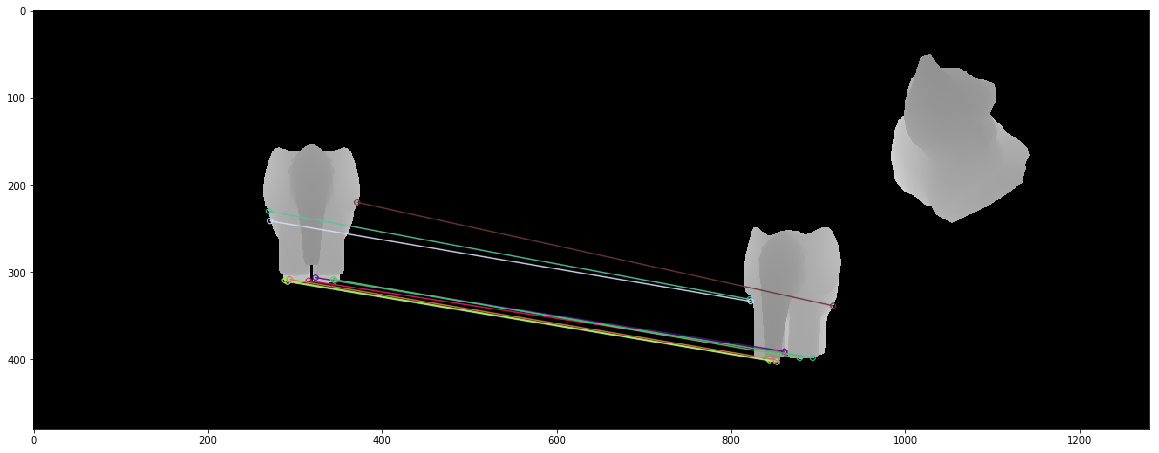

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


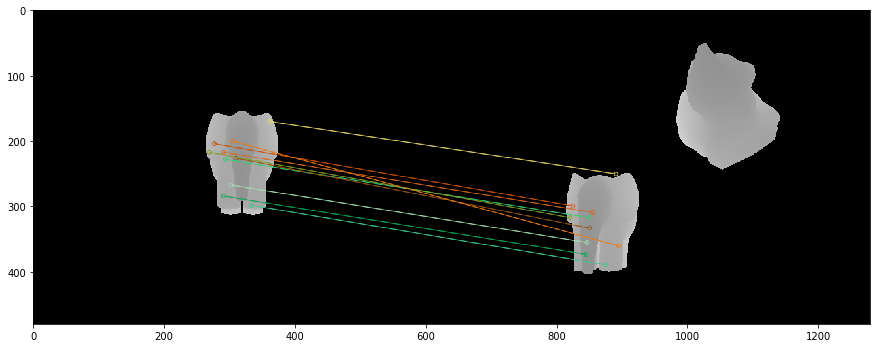

In [57]:
print("ORB: ")
run_ORB("elephant_cat", "elephant", num_matches=10)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "elephant_cat", "elephant", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "elephant_cat", "elephant", num_matches=10, patch_size=None)

Basic ORB: 
Using openCV norm_hammings


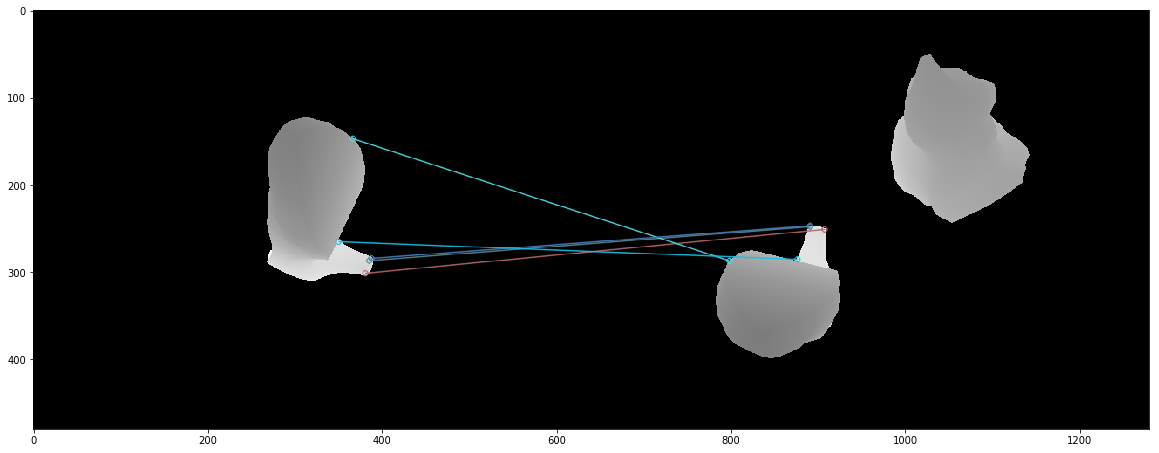

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


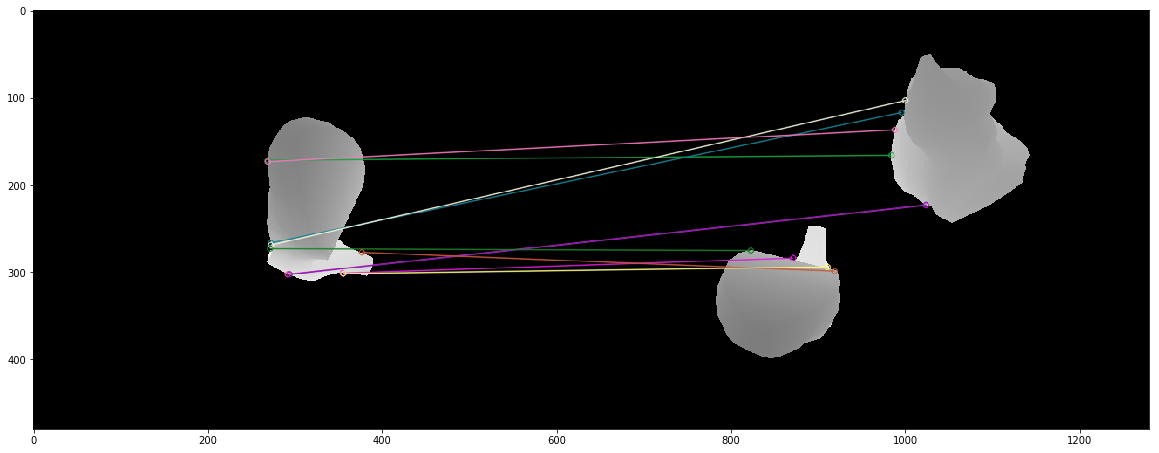

normalizing descriptor norm
normalizing descriptor norm
Using simple match


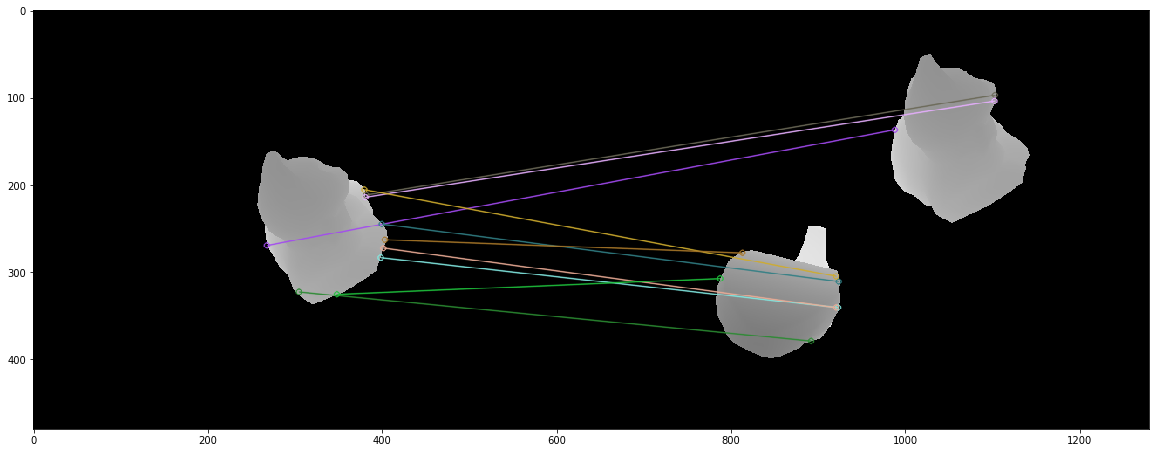

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


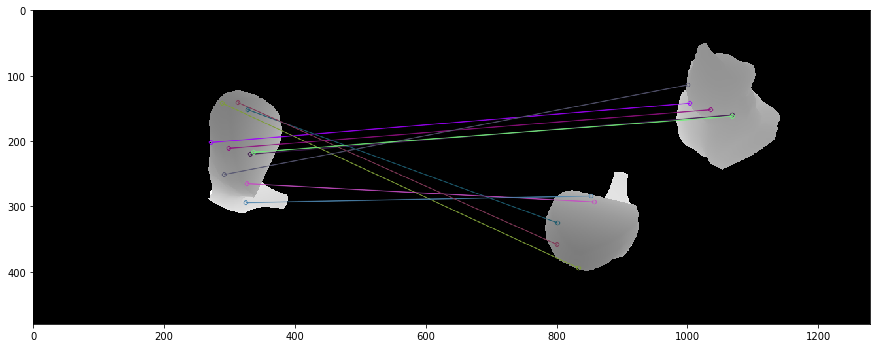

In [50]:
print("Basic ORB: ")
run_ORB("blackshoes_cat", "blackshoes", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "blackshoes_cat", "blackshoes", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "blackshoes_cat", "cat", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "blackshoes_cat", "blackshoes", num_matches=10)

Basic ORB: 
Using openCV norm_hammings


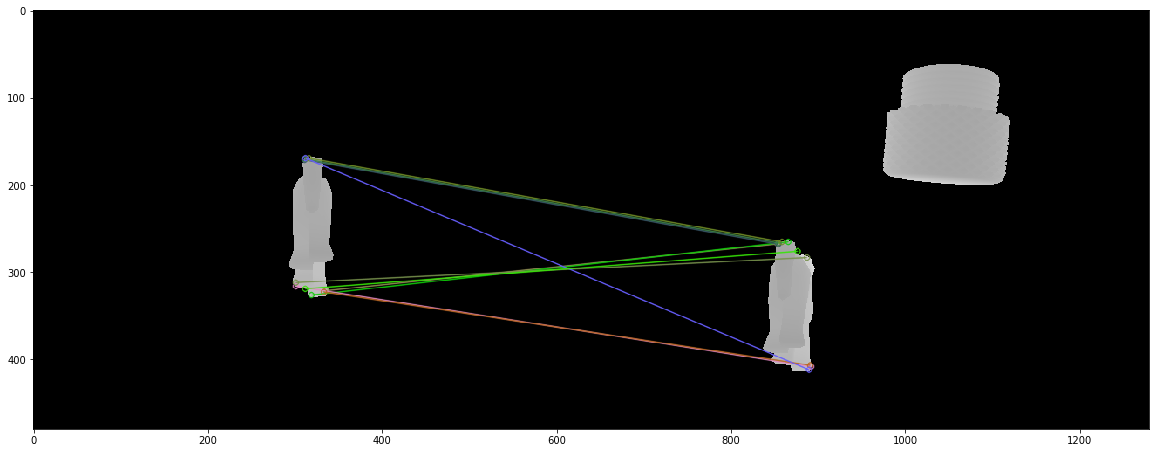

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


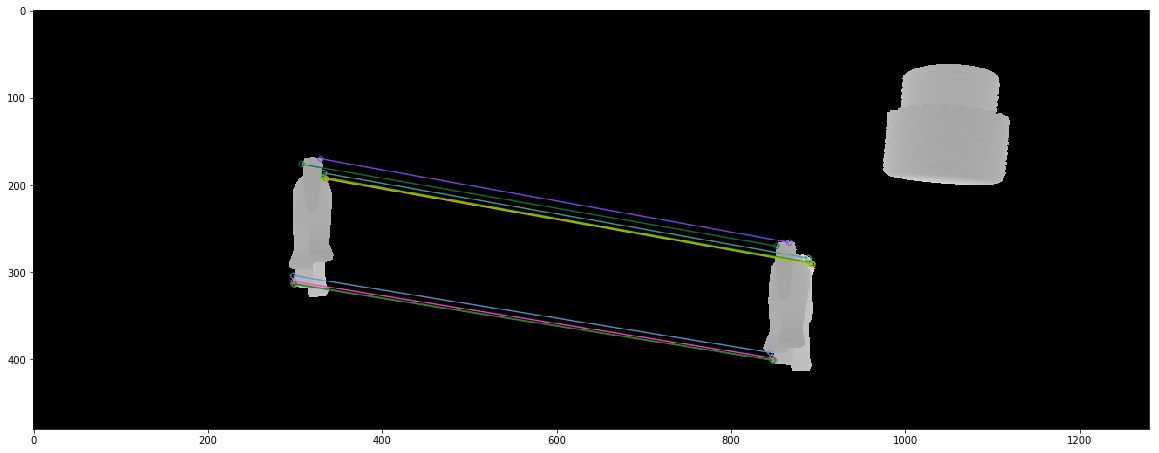

normalizing descriptor norm
normalizing descriptor norm
Using simple match


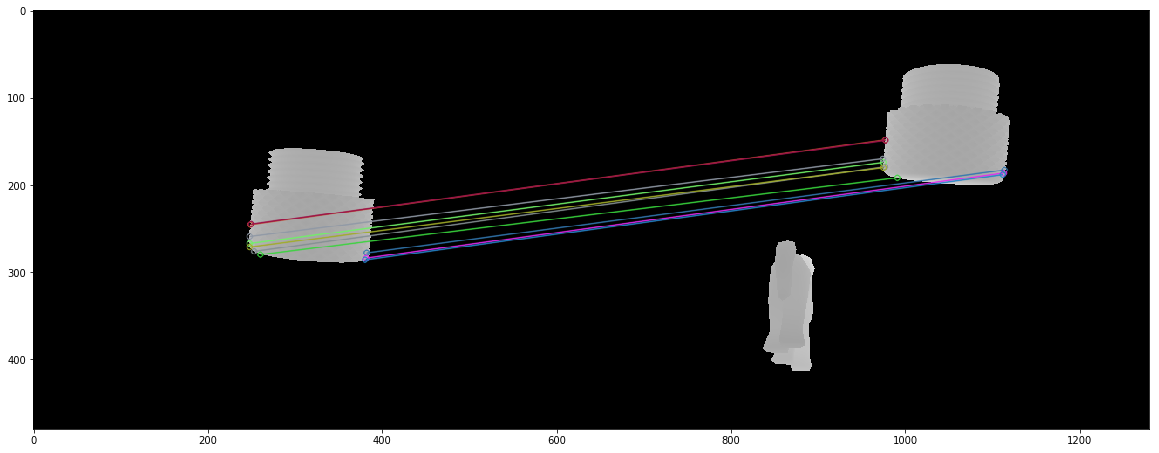

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


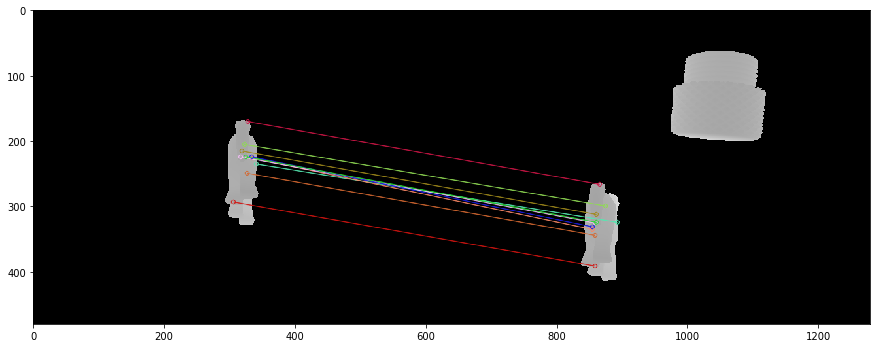

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


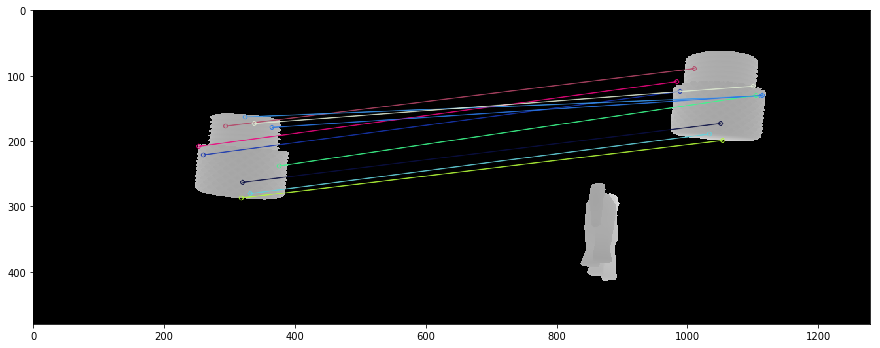

In [51]:
print("Basic ORB: ")
run_ORB("horse_spiky_screw", "horse", num_matches=10)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "horse_spiky_screw", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "horse_spiky_screw", "spiky_screw", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "horse_spiky_screw", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "horse_spiky_screw", "spiky_screw", num_matches=10)

Basic ORB: 
Using openCV norm_hammings


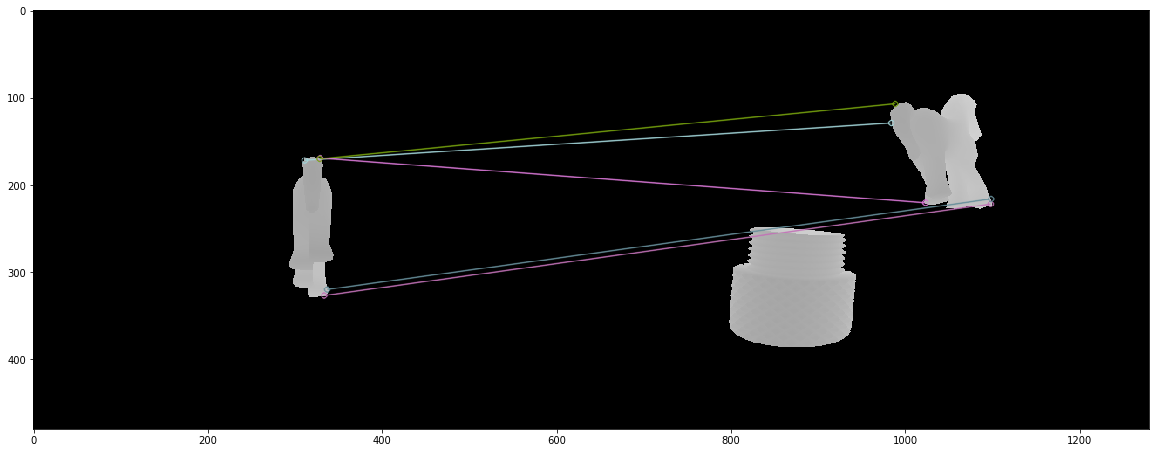

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


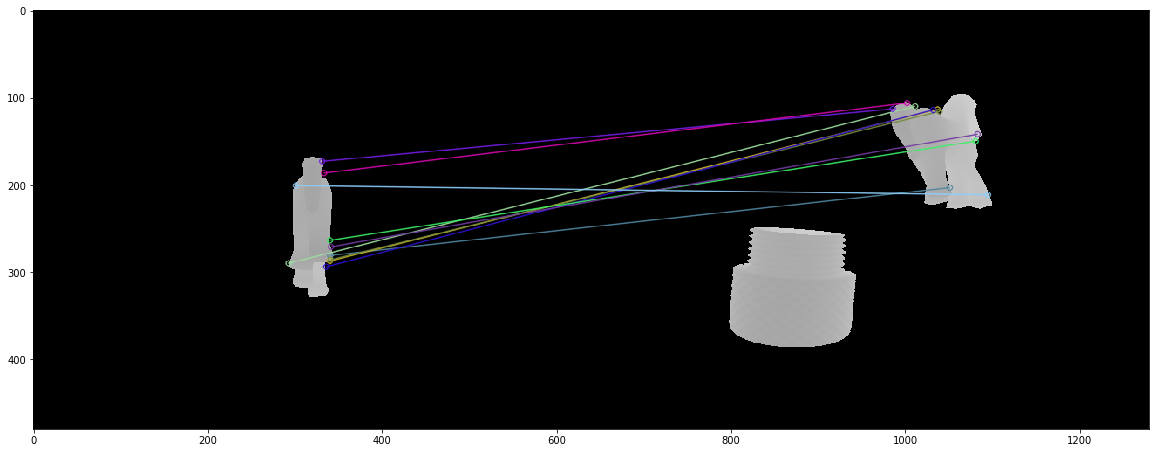

normalizing descriptor norm
normalizing descriptor norm
Using simple match


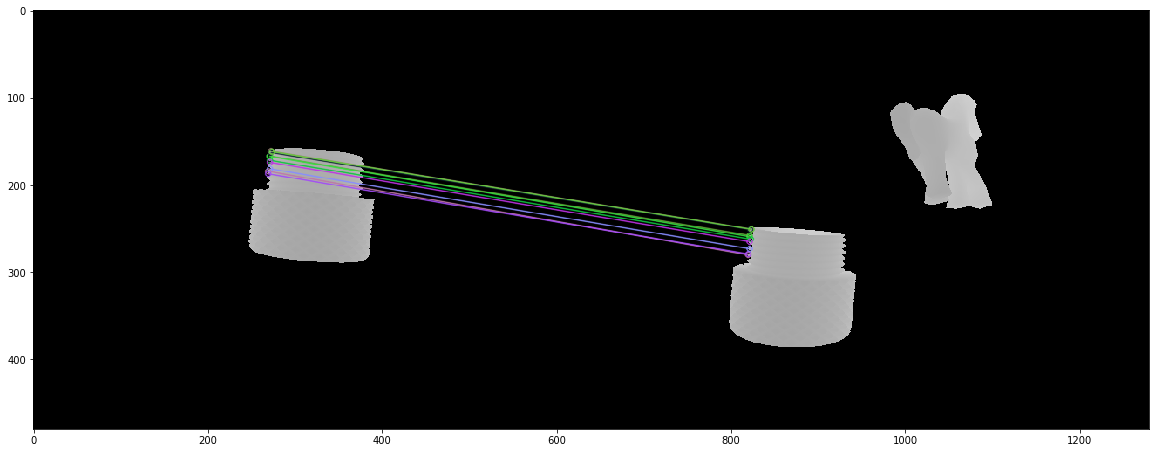

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


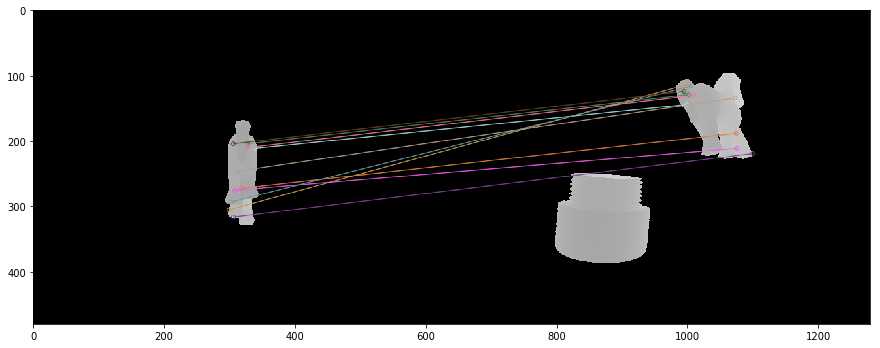

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


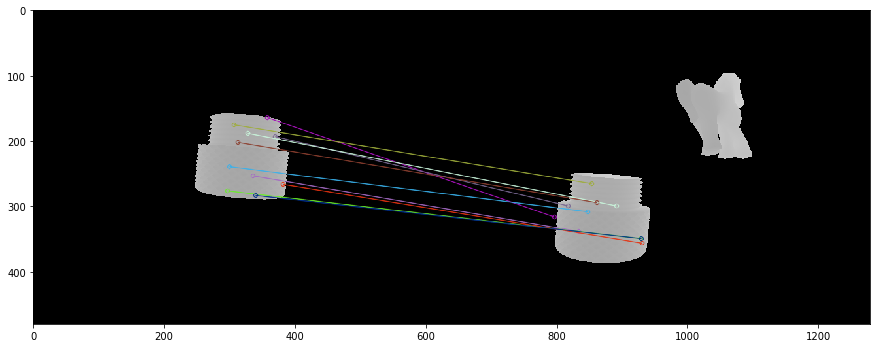

In [52]:
print("Basic ORB: ")
run_ORB("spiky_screw_horse", "horse", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "spiky_screw_horse", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "spiky_screw_horse", "spiky_screw", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "spiky_screw_horse", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "spiky_screw_horse", "spiky_screw", num_matches=10)

Basic ORB: 
Using openCV norm_hammings


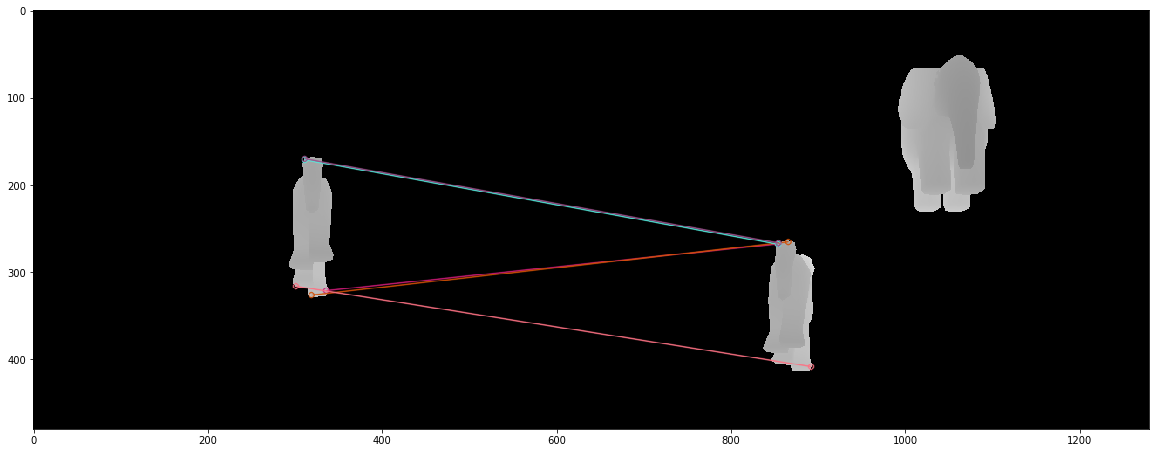

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


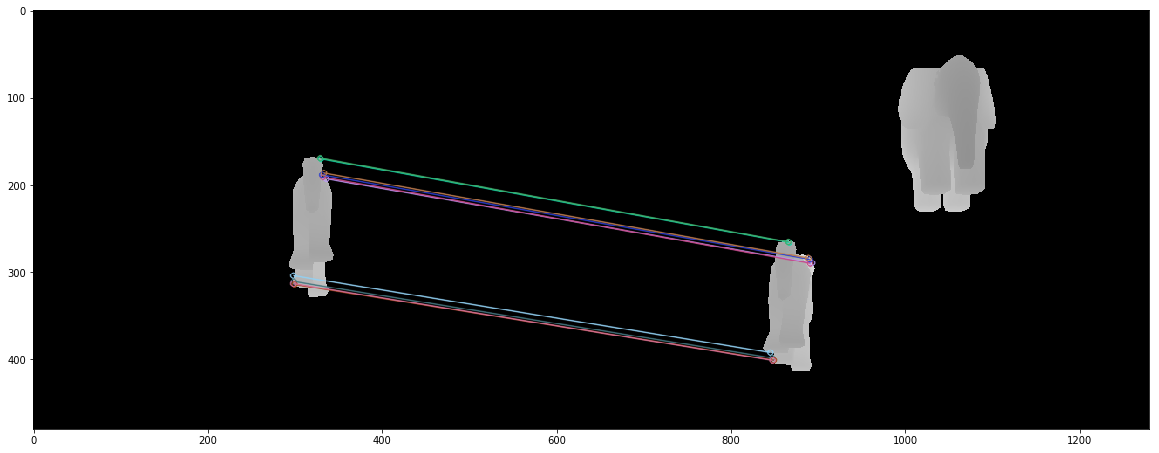

normalizing descriptor norm
normalizing descriptor norm
Using simple match


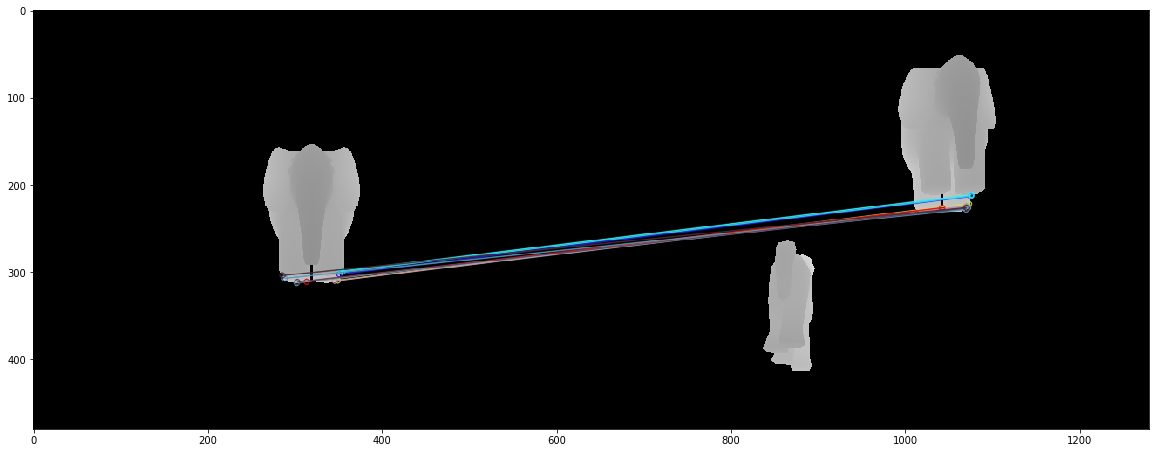

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


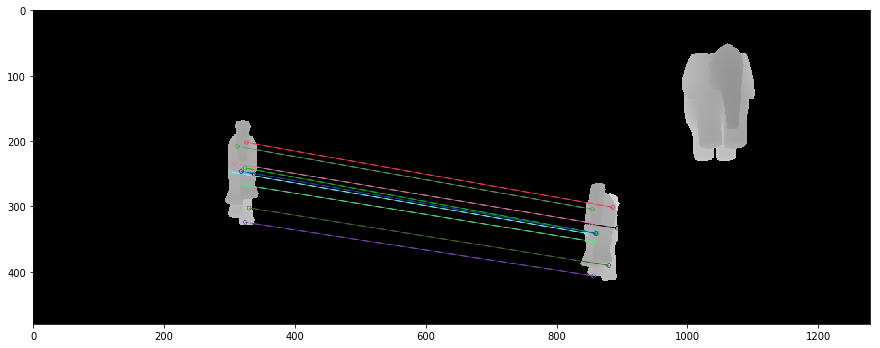

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


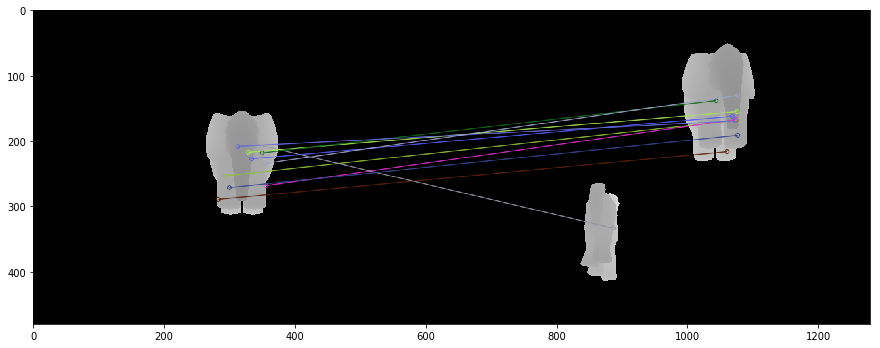

In [53]:
print("Basic ORB: ")
run_ORB("horse_elephant", "horse", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "horse_elephant", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "horse_elephant", "elephant", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "horse_elephant", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "horse_elephant", "elephant", num_matches=10)

Basic ORB: 
Using openCV norm_hammings


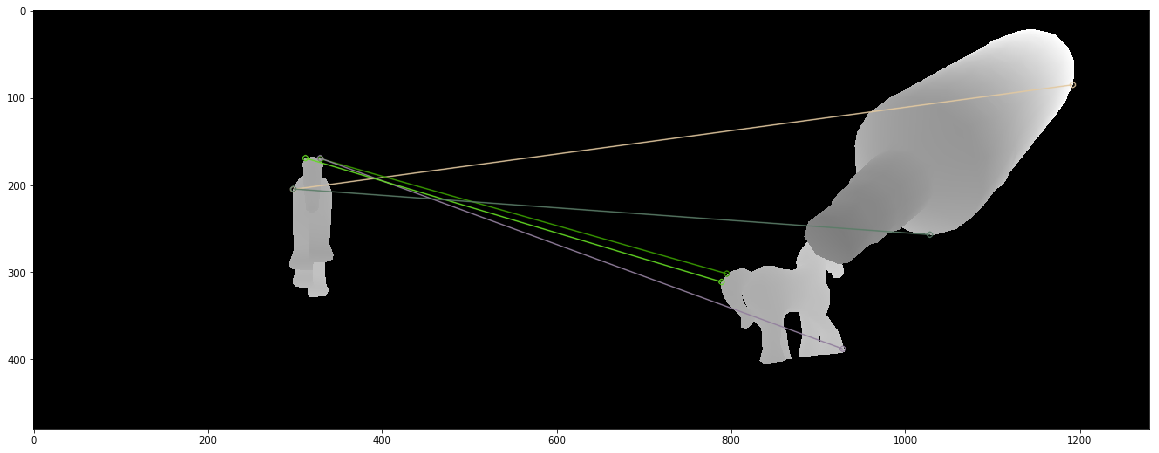

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


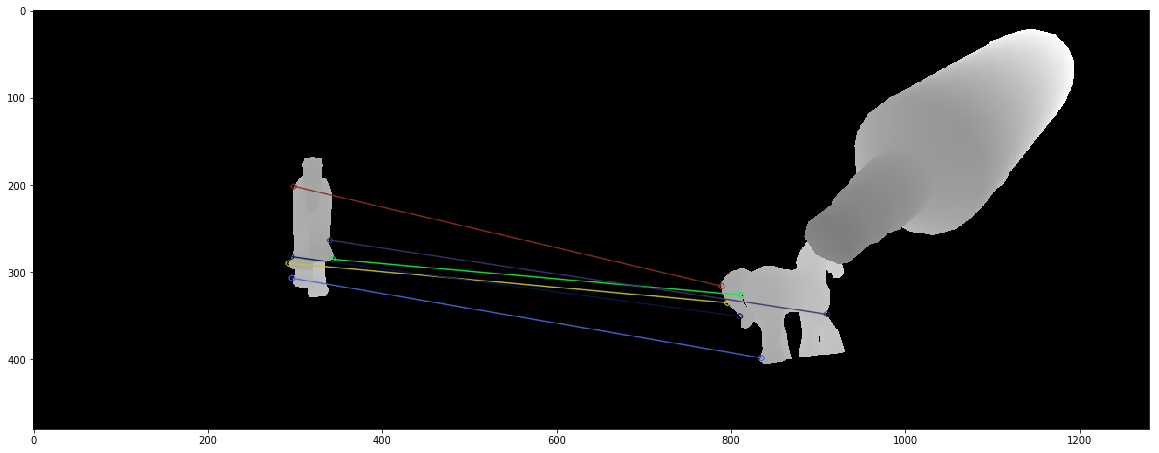

normalizing descriptor norm
normalizing descriptor norm
Using simple match


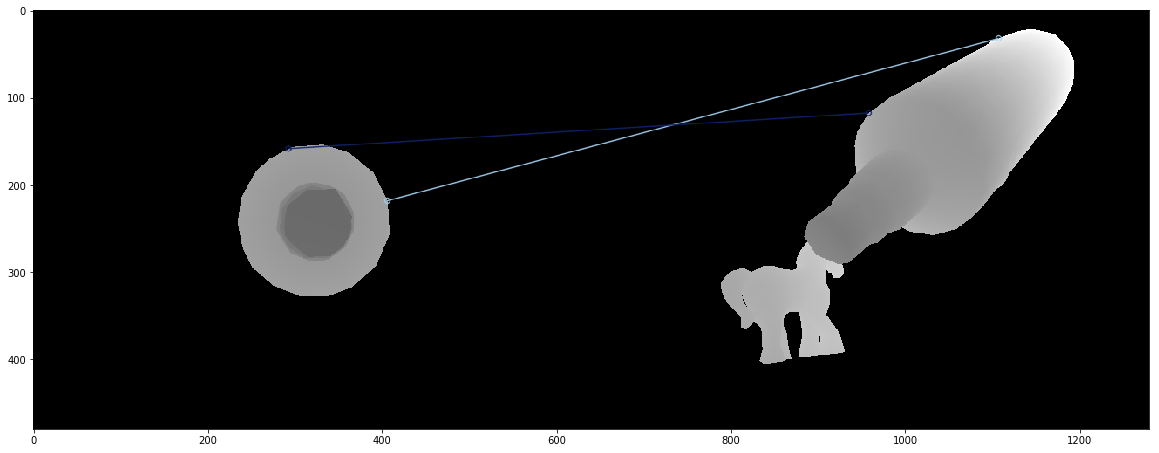

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


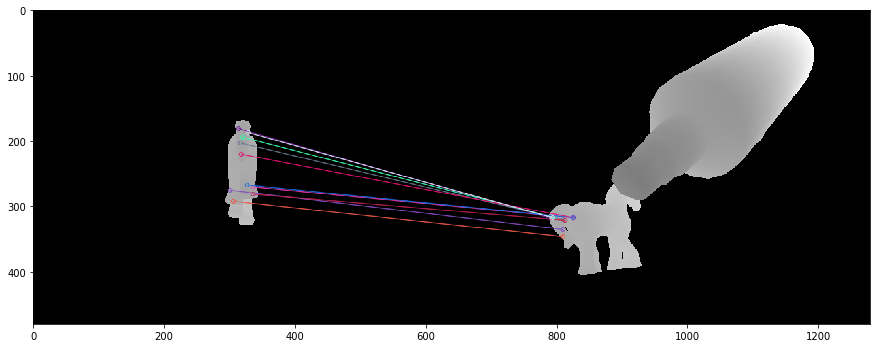

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


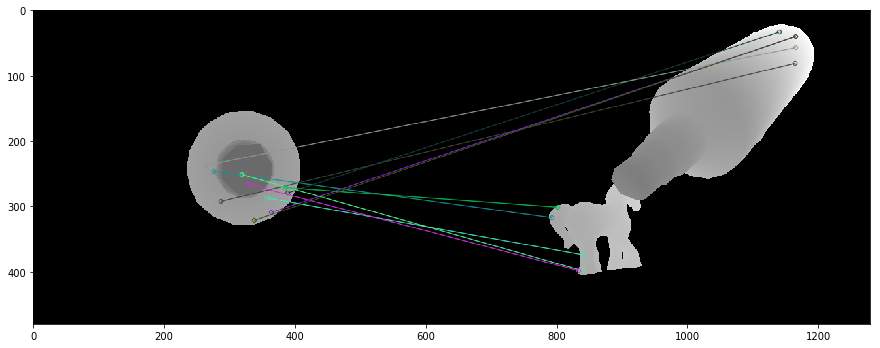

In [54]:
heap_name = "horse_bottle"
obj1 = "horse"
obj2 = "bottle"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)

Basic ORB: 
Using openCV norm_hammings


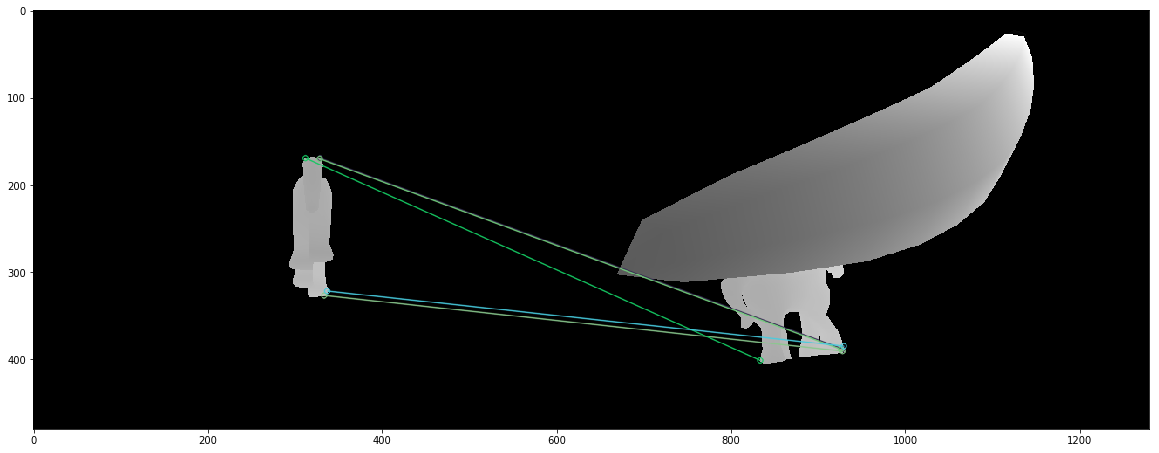

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


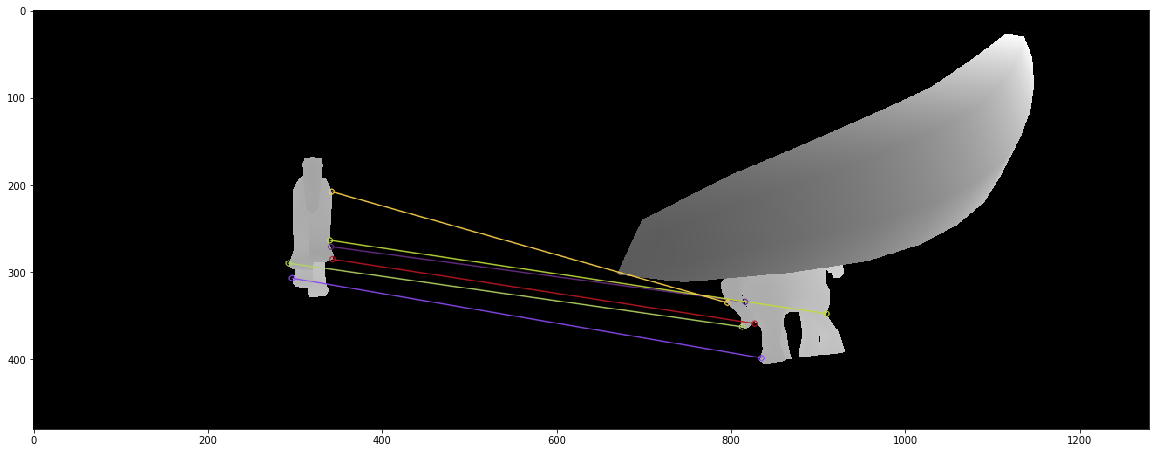

normalizing descriptor norm
normalizing descriptor norm
Using simple match


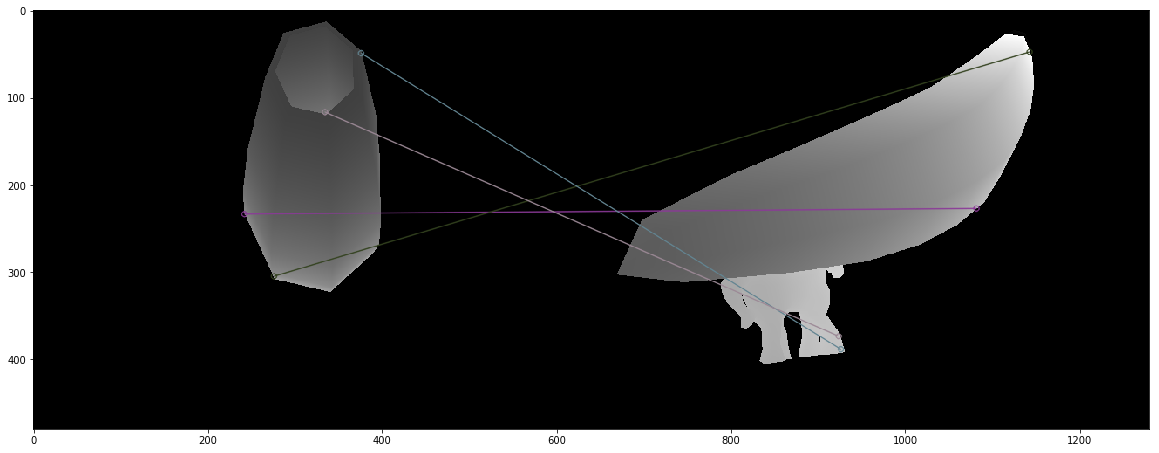

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


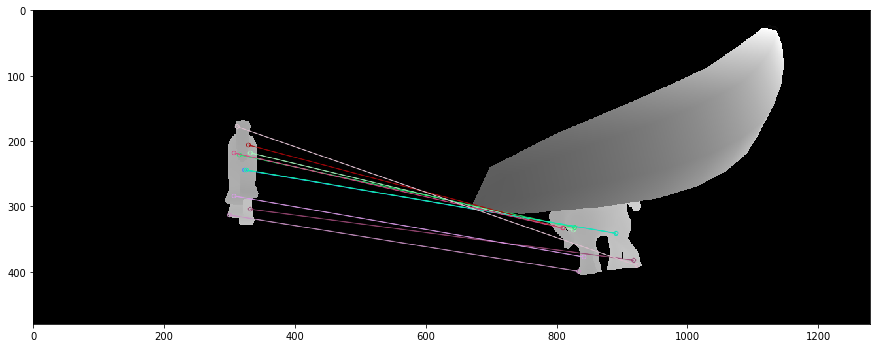

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


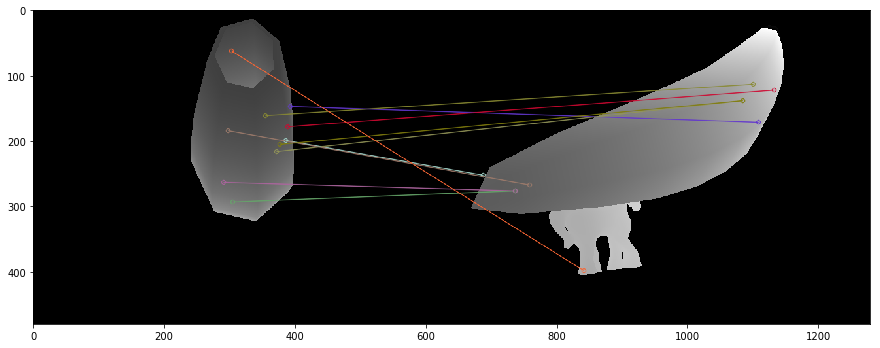

In [55]:
heap_name = "horse_banana"
obj1 = "horse"
obj2 = "banana"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)

Basic ORB: 
Using openCV norm_hammings


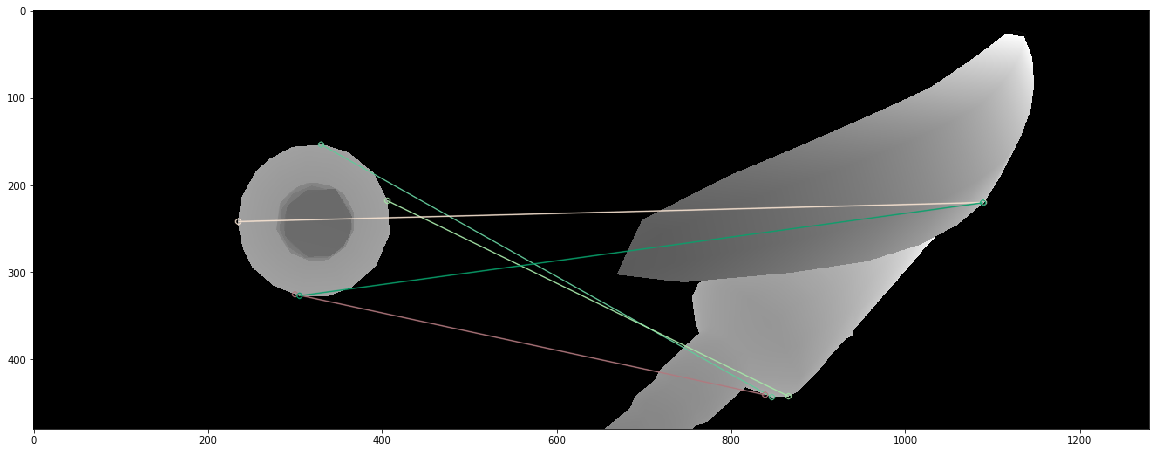

Using openCV norm_hammings


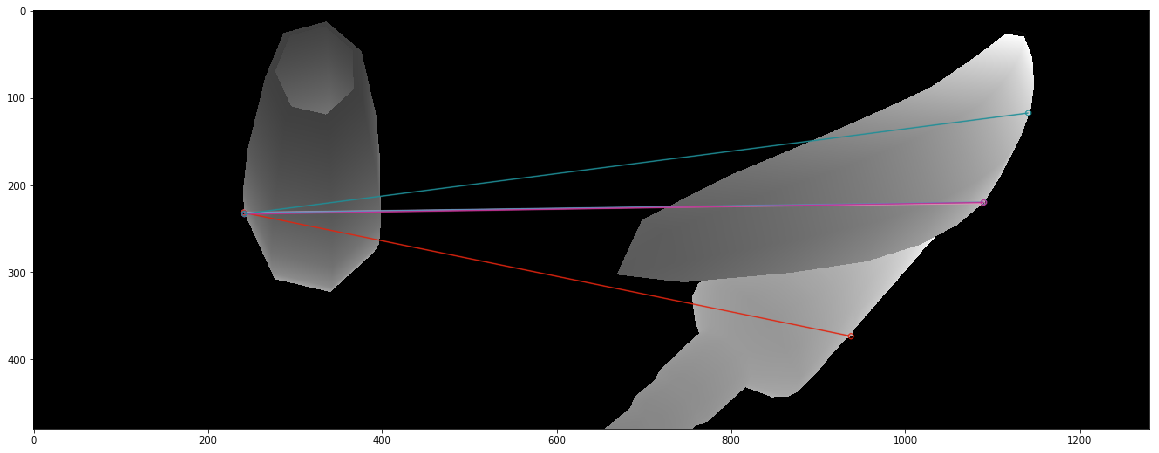

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


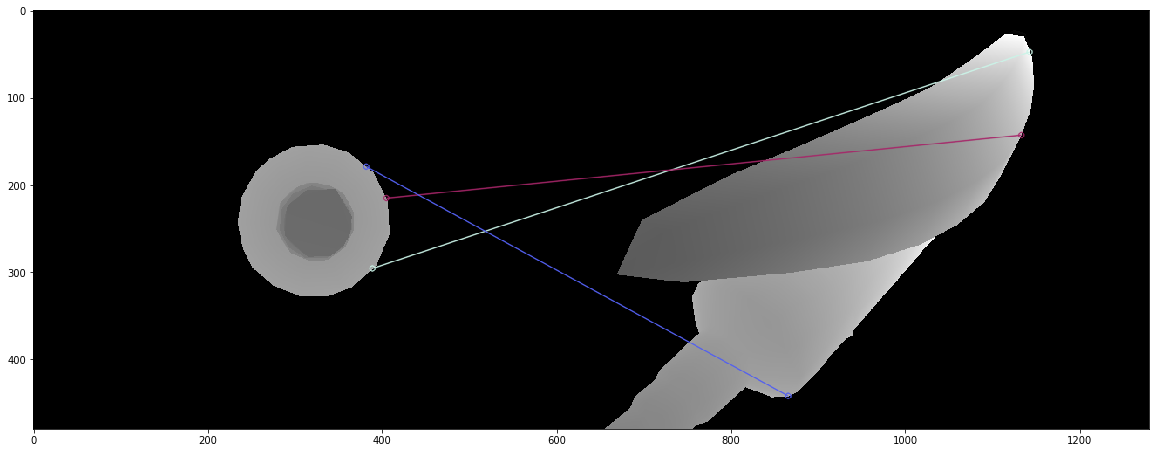

normalizing descriptor norm
normalizing descriptor norm
Using simple match


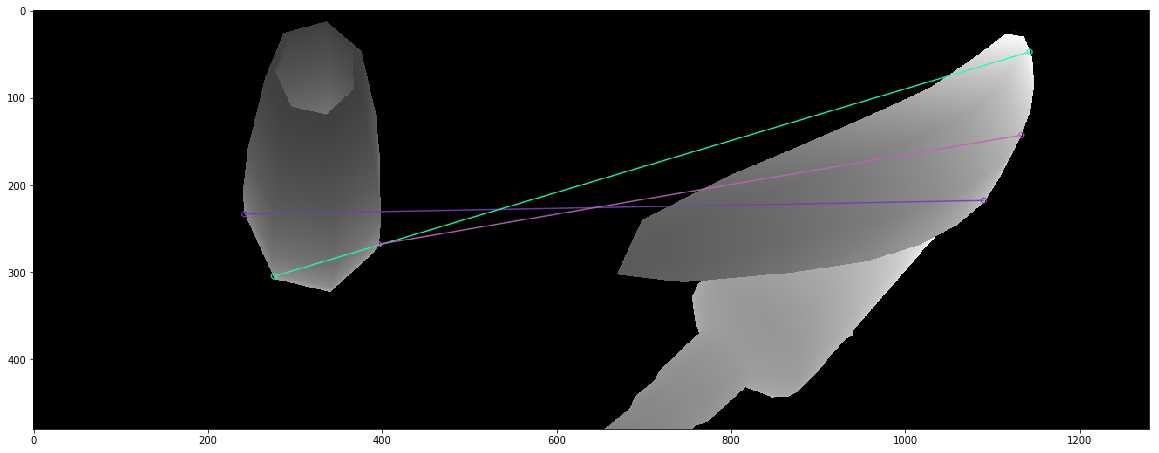

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


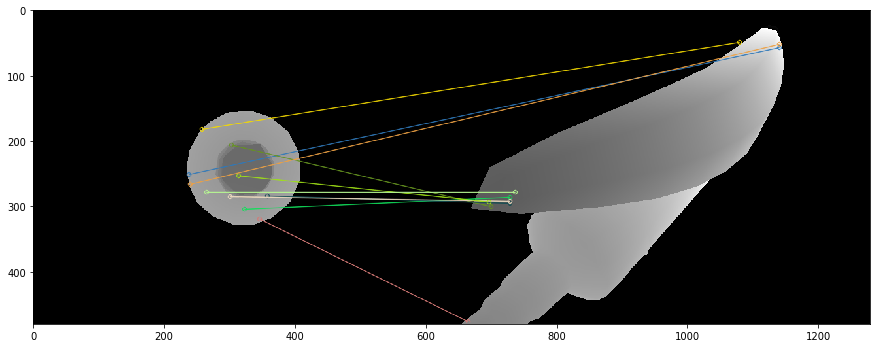

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


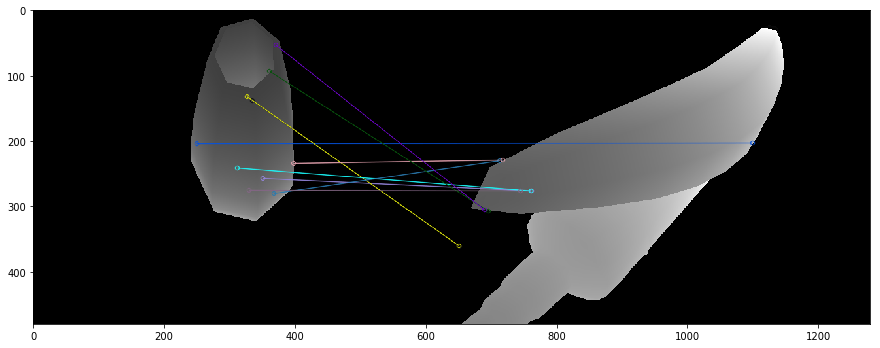

In [56]:
heap_name = "bottle_banana"
obj1 = "bottle"
obj2 = "banana"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
run_ORB(heap_name, obj2, num_matches=5)

print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)